In [1]:
# NOTE: Used a Python3 kernel to run this.
#       It may work for Python2 kernels as well, 
#       but no garanties given.

import os
import gzip
import time
try:
    import cPickle as pickle  # python2
except ImportError:
    import pickle # python3
    
import numpy as np
import tensorflow as tf
from tensorflow.python.client import device_lib

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc 
# use font and figure size for latex
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
textwidth_tex_a4 = 6.27
fig_factor = 0.9
golden_ratio = 1.6180339887
rc('figure', figsize=(fig_factor*textwidth_tex_a4, fig_factor*textwidth_tex_a4/golden_ratio))


## Implementing LeNet in Tensorflow

In [2]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = pickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

In [3]:

# load
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval
X_test, y_test = Dtest

# Downsample training data to make it a bit faster for testing this code
n_train_samples = 10000
train_idxs = np.random.permutation(X_train.shape[0])[:n_train_samples]
X_train_subset = X_train[train_idxs]
y_train_subset = y_train[train_idxs]

X_train = X_train.swapaxes(1,3)
X_train_subset = X_train_subset.swapaxes(1,3)
X_valid = X_valid.swapaxes(1,3)
X_test = X_test.swapaxes(1,3)

... loading data
... done loading data


In [4]:
class LeNet():
    def __init__(self, init_stddev=0.1, n_filter=16, max_batch_size=10000):
        self.max_batch_size = max_batch_size
        self.X_placeholder = tf.placeholder(tf.float32, (None, 28, 28, 1))
        self.y_placeholder = tf.placeholder(tf.float32, (None, 10))
        self.network_graph = self._network_graph(init_stddev,
                                                 n_filter)
        self.classification_error_graph = self._classification_error_graph()
        self.loss_graph = self._loss_graph()

        
    def _run(self, graph, X, y):
        data = {self.X_placeholder: X, 
                self.y_placeholder: y}
        return self._session.run(graph, feed_dict=data)
    
    def _run_batched(self, graph, X, y, batch_size):
        n_samples = X.shape[0]
        n_batches = int(np.ceil(n_samples / batch_size))
        sizes = []
        results = []
        for b in range(n_batches):
            batch_start = b * batch_size
            batch_end = min(n_samples, batch_start + batch_size)
        
            X_batch = X[batch_start:batch_end,]
            y_batch = y[batch_start:batch_end,]
            batch_result = self._run(graph, X_batch, y_batch)
            
            sizes.append(batch_end - batch_start)
            results.append(batch_result)
        return sizes, results
      
    def _gd_step_graph(self, learning_rate):
        gd = tf.train.GradientDescentOptimizer(learning_rate)
        return gd.minimize(self._loss_graph())
    
    def _loss_graph(self):
        negsum = -tf.reduce_sum(self.y_placeholder *
                                    tf.log(self.network_graph), 
                                axis=[1])
        cross_entropy = tf.reduce_mean(negsum)
        return cross_entropy
    
    def _classification_error_graph(self):
        wrong_pred = tf.not_equal(tf.argmax(self.y_placeholder, 1),
                                  tf.argmax(self.network_graph, 1))
        error_graph = tf.reduce_mean(tf.cast(wrong_pred, tf.float32))
        return error_graph
        
    def loss(self, X, y):
        batch_size, batch_loss = self._run_batched(self.loss_graph, 
                                                   X, y,
                                                   self.max_batch_size)
        n_samples = sum(batch_size)
        return np.mean(np.array(batch_size)  / n_samples * np.array(batch_loss))
        
    def classification_error(self, X, y, y_one_hot=True):
        if y_one_hot:
            y = one_hot(y)
        batch_size, batch_error = self._run_batched(self.classification_error_graph, 
                                                    X, y,
                                                    self.max_batch_size)
        n_samples = sum(batch_size)
        return np.mean(np.array(batch_size) / n_samples * np.array(batch_error))
        

    def _network_graph(self, init_stddev, n_filter):
        def conv(x):
            filter_shape = [3, 3, x.shape[-1].value, n_filter]
            W = tf.Variable(tf.random_normal(filter_shape, 
                                             stddev=init_stddev))
            b = tf.Variable(tf.random_normal(filter_shape[-1:],
                                             stddev=init_stddev))
            return tf.nn.conv2d(x, W,             
                                strides=[1, 1, 1, 1],
                                padding='SAME') + b
        def max_pool(x):
            return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                                  strides=[1, 2, 2, 1],
                                  padding='SAME')

        def fully_connected(x, n_units):
            x_flat = tf.reshape(x, [-1, np.prod(x.shape[1:]).value])
            W = tf.Variable(tf.random_normal([x_flat.shape[1].value, n_units], 
                                             stddev=init_stddev))
            b = tf.Variable(tf.random_normal([n_units], 
                                             stddev=init_stddev))
            return tf.matmul(x_flat,W) + b
    
        x = self.X_placeholder
        conv1 = conv(x)
        act1 = tf.nn.relu(conv1)
        pool1 = max_pool(act1)
        conv2 = conv(pool1)
        act2 = tf.nn.relu(conv2)
        pool2 = max_pool(act2)
        full1 = fully_connected(pool2, n_units=128)
        full2 = fully_connected(full1, n_units=10)
        y_pred = tf.nn.softmax(full2)
        return y_pred
    
    def sdg_epoch(self, X, y, learning_rate, batch_size):
        step = self._gd_step_graph(learning_rate)
        return self._run_batched(step, X, y, batch_size)
     
    def train(self, X, y, X_valid, y_valid, learning_rate=0.1,
              max_epochs=100, batch_size=64, y_one_hot=True):
        print("... setup training")
        if y_one_hot:
            y_1hot = one_hot(y)
            y_valid_1hot = one_hot(y_valid)
        else:
            y_1hot = y
            y_valid_1hot = y_valid
        trace = dict(train_loss=[], train_error=[], valid_error=[])
       
        print("... starting training")
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self._session = sess
            for e in range(1, max_epochs+1):
                self.sdg_epoch(X, y_1hot, learning_rate, batch_size)
                
                train_loss = self.loss(X, y_1hot)
                train_error = self.classification_error(X, y_1hot,
                                                        y_one_hot=False)
                valid_error = self.classification_error(X_valid, y_valid_1hot,
                                                        y_one_hot=False)
                trace['train_loss'].append(train_loss)
                trace['train_error'].append(train_error)
                trace['valid_error'].append(valid_error) 
                print(('epoch {}: loss {:.4f}, ' +
                        'train error {:.4f}, ' + 
                        'valid error {:.4f}' +
                        '').format(e, train_loss, 
                                   train_error, valid_error))
        return trace

## Changing the Learning Rate

Which conclusions could be drawn from this figure?

Which value for the learning rate works best?

In [5]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
error_per_learning_rate = dict()

train_config = dict(max_epochs=15, batch_size=64,
                    y_one_hot=True)

lenet = LeNet(init_stddev=0.1, n_filter=16)
for learning_rate in learning_rates:
    print("USE LEARN RATE {}".format(learning_rate))
    trace = lenet.train(X_train, y_train,
                        X_valid, y_valid,
                        learning_rate=learning_rate,
                        **train_config)
    error_per_learning_rate[str(learning_rate)] = trace['valid_error']
    

USE LEARN RATE 0.1
... setup training
... starting training
epoch 1: loss 0.0249, train error 0.0077, valid error 0.0335
epoch 2: loss 0.0158, train error 0.0050, valid error 0.0243
epoch 3: loss 0.0121, train error 0.0038, valid error 0.0201
epoch 4: loss 0.0101, train error 0.0032, valid error 0.0188
epoch 5: loss 0.0087, train error 0.0027, valid error 0.0183
epoch 6: loss 0.0077, train error 0.0024, valid error 0.0175
epoch 7: loss 0.0070, train error 0.0021, valid error 0.0163
epoch 8: loss 0.0065, train error 0.0020, valid error 0.0163
epoch 9: loss 0.0061, train error 0.0020, valid error 0.0153
epoch 10: loss 0.0056, train error 0.0019, valid error 0.0154
epoch 11: loss 0.0053, train error 0.0017, valid error 0.0152
epoch 12: loss 0.0051, train error 0.0016, valid error 0.0150
epoch 13: loss 0.0048, train error 0.0016, valid error 0.0151
epoch 14: loss 0.0047, train error 0.0016, valid error 0.0152
epoch 15: loss 0.0045, train error 0.0015, valid error 0.0150
USE LEARN RATE 0.01

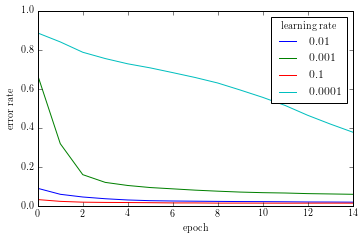

In [6]:
for learning_rate, error in error_per_learning_rate.items():
    plt.plot(error, label=learning_rate)
plt.legend(title='learning rate', loc='best')
plt.ylim((0, 1))
plt.xlabel('epoch')
plt.ylabel('error rate')

plt.savefig('../report/assets/error.pdf')
plt.show()

## Runtime CPU vs GPU

How does the number of parameters
change if you increase the number of filters? 

How does the runtime change? 

At last, run the same experiments again on a CPU, How does the plot change?

In [14]:
gpu_filters = [8, 16, 32, 64, 128, 256]
cpu_filters = [8, 16, 32, 64]

devices = device_lib.list_local_devices()
cpus = [d for d in devices if d.device_type == 'CPU']
gpus = [d for d in devices if d.device_type == 'GPU']

train_config = dict(max_epochs=10, batch_size=64,
                    learning_rate=0.1, y_one_hot=True)

def check_time(filters):
    times = []
    for n_filter in filters:
        print("USE #FILTER {}".format(n_filter))
        start = time.time()
        lenet = LeNet(init_stddev=0.1, 
                      n_filter=n_filter, 
                      max_batch_size=int(32/n_filter*10000))
        trace = lenet.train(X_train, y_train,
                            X_valid, y_valid,
                            **train_config)
        end = time.time()
        times.append(end - start)
    return times

In [15]:
gpu_time = []
cpu_time = []

if len(gpus) > 0:
    print("USE GPU")
    with tf.device(gpus[0].name):
        gpu_time = check_time(gpu_filters)
        
if len(cpus) > 0:
    print("USE CPU")
    with tf.device(cpus[0].name):
        cpu_time = check_time(cpu_filters)

USE GPU
USE #FILTER 8
... setup training
... starting training
epoch 1: loss 0.0840, train error 0.0257, valid error 0.0467
epoch 2: loss 0.0562, train error 0.0172, valid error 0.0305
epoch 3: loss 0.0454, train error 0.0139, valid error 0.0255
epoch 4: loss 0.0389, train error 0.0118, valid error 0.0228
epoch 5: loss 0.0339, train error 0.0105, valid error 0.0207
epoch 6: loss 0.0314, train error 0.0099, valid error 0.0202
epoch 7: loss 0.0293, train error 0.0094, valid error 0.0192
epoch 8: loss 0.0283, train error 0.0093, valid error 0.0180
epoch 9: loss 0.0267, train error 0.0087, valid error 0.0172
epoch 10: loss 0.0257, train error 0.0083, valid error 0.0168
USE #FILTER 16
... setup training
... starting training
epoch 1: loss 0.0361, train error 0.0114, valid error 0.0302
epoch 2: loss 0.0252, train error 0.0081, valid error 0.0233
epoch 3: loss 0.0196, train error 0.0062, valid error 0.0194
epoch 4: loss 0.0173, train error 0.0056, valid error 0.0181
epoch 5: loss 0.0156, trai

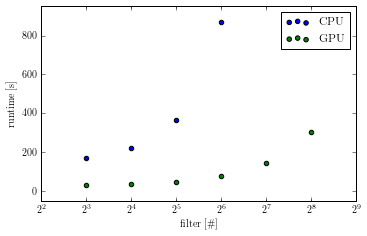

In [23]:
if len(cpu_filters) == len(cpu_time):
    plt.scatter(cpu_filters, cpu_time, label='CPU', c='b')

if len(gpu_filters) == len(gpu_time):
    plt.scatter(gpu_filters, gpu_time, label='GPU', c='g')
    
plt.legend(loc='best')
plt.xlabel('filter [\#]')
plt.ylim(-50, 950)
plt.xscale('log', basex=2)
plt.ylabel('runtime [s]')

plt.savefig('../report/assets/runtime.pdf')
plt.show()